change the location to where you place the dataset

In [1]:
!wget https://raw.githubusercontent.com/PacktPublishing/Machine-Learning-for-Imbalanced-Data/main/data/cifar10-lt_train.npz
!wget https://raw.githubusercontent.com/PacktPublishing/Machine-Learning-for-Imbalanced-Data/main/data/cifar10_test.npz

--2023-12-22 20:39:32--  https://raw.githubusercontent.com/PacktPublishing/Machine-Learning-for-Imbalanced-Data/main/data/cifar10-lt_train.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50180223 (48M) [application/octet-stream]
Saving to: ‘cifar10-lt_train.npz’

cifar10-lt_train.np 100%[===================>]  47.86M  57.5MB/s    in 0.8s    

2023-12-22 20:39:36 (57.5 MB/s) - ‘cifar10-lt_train.npz’ saved [50180223/50180223]

--2023-12-22 20:39:36--  https://raw.githubusercontent.com/PacktPublishing/Machine-Learning-for-Imbalanced-Data/main/data/cifar10_test.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.19

Define a customized dataset to read data for us

In [2]:
from torch.utils.data import Dataset
import numpy as np
import random
import torch

rand_seed = 1
random.seed(rand_seed)
torch.manual_seed(rand_seed)
np.random.seed(rand_seed)


class MyDataset(Dataset):
    def __init__(self, train=True):
        if train:
            data = np.load("./cifar10-lt_train.npz")
        else:
            data = np.load("./cifar10_test.npz")
        self.label = data["arr_1"]
        self.data = data["arr_0"]

    def __getitem__(self, index):
        img = np.squeeze(self.data[index], axis=0)
        img = np.transpose(img, (2, 0, 1))
        return {"img": img, "label": self.label[index, 0]}

    def __len__(self):
        return len(self.data)

# Show some metrics about CIFAR10-LT training data

Distribution of classes in imbalanced dataset:


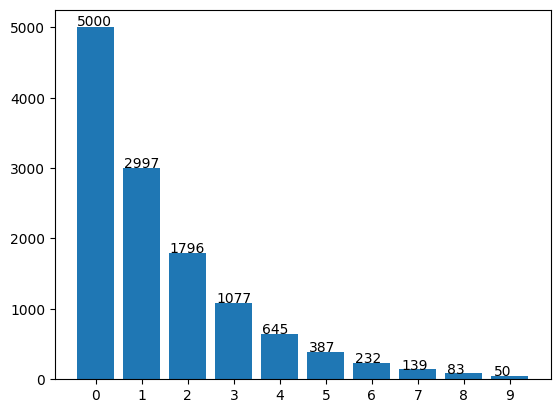

In [3]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

data = DataLoader(MyDataset(train=True), batch_size=16, shuffle=True, num_workers=2)

num_classes = 10
classe_labels = range(num_classes)

print("Distribution of classes in imbalanced dataset:")
fig, ax = plt.subplots()
_, counts = np.unique(data.dataset.label, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

Start train with cross entropy loss

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
100%|██████████| 313/313 [00:02<00:00, 106.90it/s]


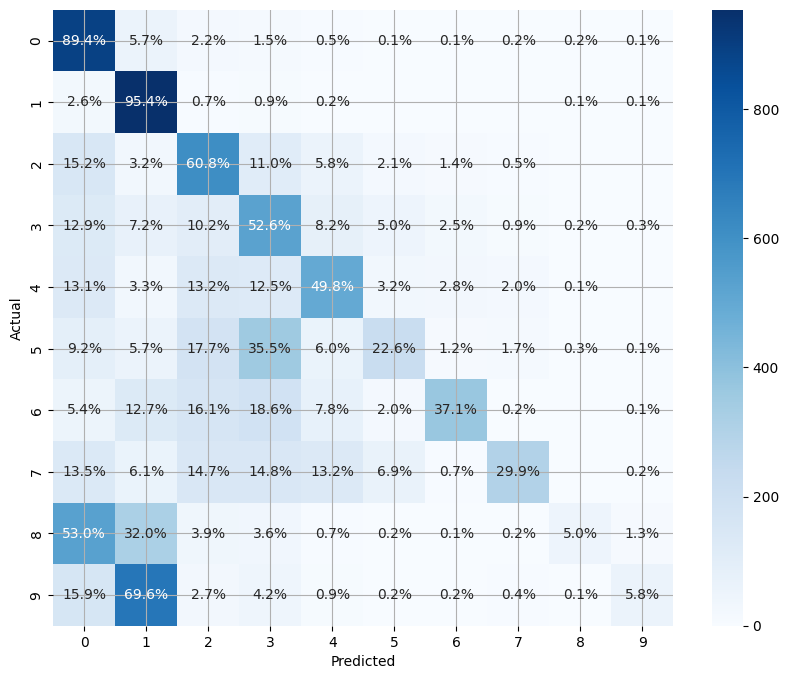

In [4]:
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

accuracy_ce = []


def train():
    train_dataloader = DataLoader(
        MyDataset(train=True), batch_size=16, shuffle=True, num_workers=2
    )
    test_dataloader = DataLoader(
        MyDataset(train=False), batch_size=32, shuffle=True, num_workers=2
    )

    device = "cuda" if torch.cuda.is_available() else "cpu"
    net = torch.hub.load("pytorch/vision:v0.10.0", "resnet18", pretrained=False)
    net.fc = torch.nn.Linear(512, 10)
    net = net.to(device)
    optimizer = torch.optim.Adam(params=net.parameters(), lr=1e-3)
    crit = torch.nn.CrossEntropyLoss().to(device)

    for current_epoch in range(20):
        epoch_loss = []
        for batch_data in tqdm(train_dataloader):
            x = batch_data["img"].to(device)
            y = batch_data["label"].to(device)
            optimizer.zero_grad()
            pred = net(x)
            loss = crit(pred, y)
            epoch_loss.append(loss.item())
            loss.backward()
            optimizer.step()
        # do test
        with torch.no_grad():
            preds = []
            labels = []
            for batch_data in tqdm(test_dataloader):
                x = batch_data["img"].to(device)
                y = batch_data["label"].to(device)
                pred = net(x)
                pred = torch.argmax(pred, 1)
                preds.append(pred.detach().cpu().numpy())
                labels.append(y.detach().cpu().numpy())
            preds = np.concatenate(preds, 0)
            labels = np.concatenate(labels, 0)
            accuracy = accuracy_score(labels, preds)
            accuracy_ce.append(accuracy)
    with torch.no_grad():
        preds = []
        labels = []
        for batch_data in tqdm(test_dataloader):
            x = batch_data["img"].to(device)
            y = batch_data["label"].to(device)
            pred = net(x)
            pred = torch.argmax(pred, 1)
            preds.append(pred.detach().cpu().numpy())
            labels.append(y.detach().cpu().numpy())
        preds = np.concatenate(preds, 0)
        labels = np.concatenate(labels, 0)
        cm = confusion_matrix(labels, preds)
        cm_sum = np.sum(cm, axis=1, keepdims=True)
        cm_perc = cm / cm_sum * 100
        annot = np.empty_like(cm).astype(str)
        nrows, ncols = cm.shape
        for i in range(nrows):
            for j in range(ncols):
                c = cm[i, j]
                p = cm_perc[i, j]
                if c == 0:
                    annot[i, j] = ""
                else:
                    annot[i, j] = "%.1f%%" % p
        cm = pd.DataFrame(cm)
        cm.index.name = "Actual"
        cm.columns.name = "Predicted"
        fig = plt.figure(figsize=(10, 8))
        plt.grid(True)
        sns.heatmap(cm, annot=annot, fmt="", cmap="Blues")
        plt.show()


train()

Use focal loss to train as well

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
100%|██████████| 313/313 [00:02<00:00, 137.11it/s]


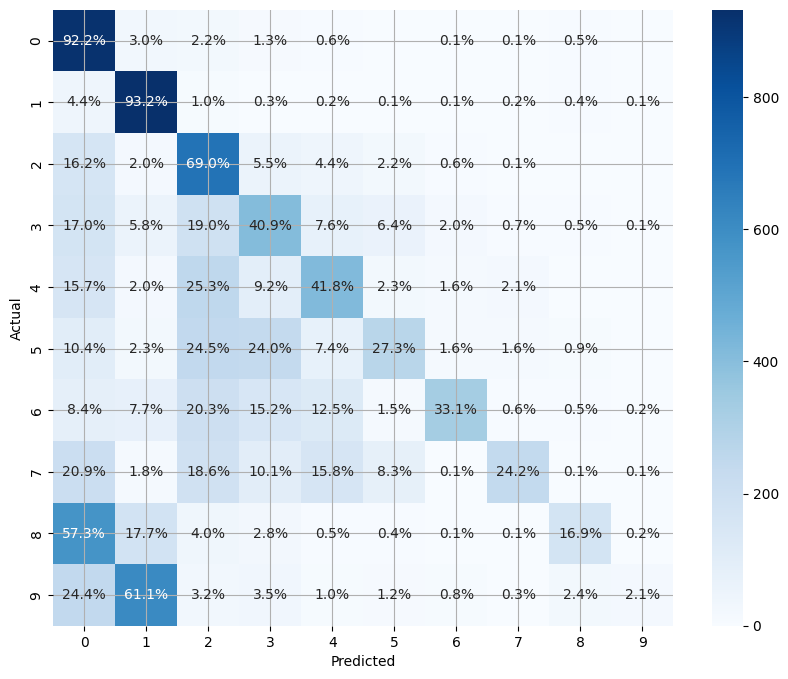

In [5]:
from torchvision.ops.focal_loss import sigmoid_focal_loss
from torch.nn.functional import one_hot

accuracy_focal = []


def train():
    train_dataloader = DataLoader(
        MyDataset(train=True), batch_size=16, shuffle=True, num_workers=2
    )
    test_dataloader = DataLoader(
        MyDataset(train=False), batch_size=32, shuffle=True, num_workers=2
    )

    device = "cuda" if torch.cuda.is_available() else "cpu"
    net = torch.hub.load("pytorch/vision:v0.10.0", "resnet18", pretrained=False)
    net.fc = torch.nn.Linear(512, 10)
    net = net.to(device)
    optimizer = torch.optim.Adam(params=net.parameters(), lr=1e-3)

    for current_epoch in range(20):
        epoch_loss = []
        for batch_data in tqdm(train_dataloader):
            x = batch_data["img"].to(device)
            y = batch_data["label"].to(device)
            optimizer.zero_grad()
            pred = net(x)
            y = one_hot(y, num_classes=10)
            loss = sigmoid_focal_loss(
                pred, y.float(), alpha=0.25, gamma=2, reduction="mean"
            )
            epoch_loss.append(loss.item())
            loss.backward()
            optimizer.step()
        # print("loss for epoch {}: {}".format(current_epoch, np.average(epoch_loss)))
        # do test
        with torch.no_grad():
            preds = []
            labels = []
            for batch_data in tqdm(test_dataloader):
                x = batch_data["img"].to(device)
                y = batch_data["label"].to(device)
                pred = net(x)
                pred = torch.argmax(pred, 1)
                preds.append(pred.detach().cpu().numpy())
                labels.append(y.detach().cpu().numpy())
            preds = np.concatenate(preds, 0)
            labels = np.concatenate(labels, 0)
            accuracy = accuracy_score(labels, preds)
            accuracy_focal.append(accuracy)
    with torch.no_grad():
        preds = []
        labels = []
        for batch_data in tqdm(test_dataloader):
            x = batch_data["img"].to(device)
            y = batch_data["label"].to(device)
            pred = net(x)
            pred = torch.argmax(pred, 1)
            preds.append(pred.detach().cpu().numpy())
            labels.append(y.detach().cpu().numpy())
        preds = np.concatenate(preds, 0)
        labels = np.concatenate(labels, 0)
        cm = confusion_matrix(labels, preds)
        cm_sum = np.sum(cm, axis=1, keepdims=True)
        cm_perc = cm / cm_sum * 100
        annot = np.empty_like(cm).astype(str)
        nrows, ncols = cm.shape
        for i in range(nrows):
            for j in range(ncols):
                c = cm[i, j]
                p = cm_perc[i, j]
                if c == 0:
                    annot[i, j] = ""
                else:
                    annot[i, j] = "%.1f%%" % p
        cm = pd.DataFrame(cm)
        cm.index.name = "Actual"
        cm.columns.name = "Predicted"
        fig = plt.figure(figsize=(10, 8))
        plt.grid(True)
        sns.heatmap(cm, annot=annot, fmt="", cmap="Blues")
        plt.show()


train()

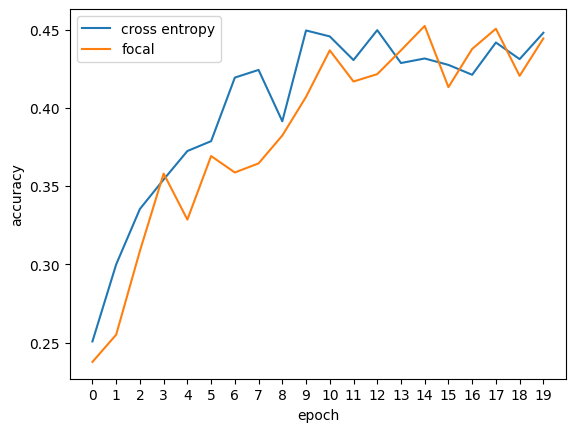

In [6]:
plt.plot(accuracy_ce, label="cross entropy")
plt.plot(accuracy_focal, label="focal")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc="upper left")
plt.xticks(range(20))
plt.show()